In [ ]:
import math as ma
import numpy as np
import matplotlib.pyplot as plt
from os.path import expanduser

from wlenet import config
from wlenet.models.calibrate import step_bias_calib, step_bias_correct
from wlenet.models.utils import get_output_dim, load_model, load_spec, save_spec, print_spec
from wlenet.dataset.io import load_sim, load_target
from wlenet.dataset.normalization import norm_mean_std
from wlenet.dataset.sequences import CorrelatedNoiseSequence, generate_batches
from wlenet.dataset.figures import show_stamps
from wlenet.models.figures import show_scatter_label_pred, show_first_conv_kernels
from wlenet.models.predict import predict, predict_test_time_aug

from wlenet.reduction.stamps import half_light_radii, chi_shapes, rrg_shapes
from scipy.stats import binned_statistic

In [2]:
save_figures = True
save_table = True
num_batches = 2000
np.random.seed(12345)

In [3]:
model_spec_cnn = load_spec('cnn_image_clash_uniform_mse_lsq')
model_spec_cnn['kwargs_dataset']['sim_names_test'] = ['clash_003_test']
model_spec_rrg = load_spec('rrg')
model_spec_rrg['kwargs_dataset']['sim_names_test'] = ['clash_003_test']

In [4]:
model_spec = model_spec_cnn
model = load_model(model_spec_cnn, load_weights=True, show_summary=False)

In [5]:
noise_kernel_path = config['calibration_path'] + '/' +  model_spec['kwargs_dataset']['noise_kernel_name'] + '_noise_kernel.npy'
noise_kernel = np.load(expanduser(noise_kernel_path)) *  model_spec['kwargs_dataset']['noise_kernel_factor']
post_sim = model_spec['kwargs_dataset']['post_sim'] if 'post_sim' in model_spec['kwargs_dataset'] else None
output_dim = get_output_dim(model)
source_test = dict(zip(('x', 'y'), load_sim(model_spec['kwargs_dataset']['sim_names_test'], 'test', output_dim, post_sim=post_sim)))
seq_test = CorrelatedNoiseSequence(source_test, noise_kernel)

In [6]:
"""
show_stamps(generate_batches(seq_test, 1)[0])
"""
pass

In [7]:
seq_test = CorrelatedNoiseSequence(source_test, noise_kernel, norm_func=None)
x_seq_test, y_seq_test, inds_seq_test = generate_batches(seq_test, num_batches)

step biases c1: 0.000, m1: 0.005, c2: -0.000, m2: 0.005
rmse1: 0.225, rmse2: 0.224, (rmse1 + rmse2)/2: 0.224


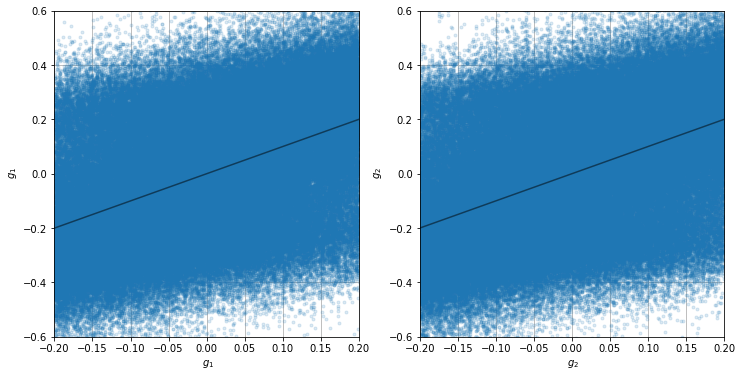

In [8]:
y_seq_ptta = predict_test_time_aug(norm_mean_std(x_seq_test), model)
y_seq_ptta_calibed, calib_ptta, rmse_ptta = step_bias_calib(y_seq_test, y_seq_ptta, verbose=True)
show_scatter_label_pred(y_seq_test, y_seq_ptta_calibed, min_g=-0.6, max_g=0.6, min_g_true=-0.2, max_g_true=0.2)

step biases c1: 0.001, m1: 0.119, c2: -0.000, m2: 0.121
rmse1: 0.257, rmse2: 0.259, (rmse1 + rmse2)/2: 0.258


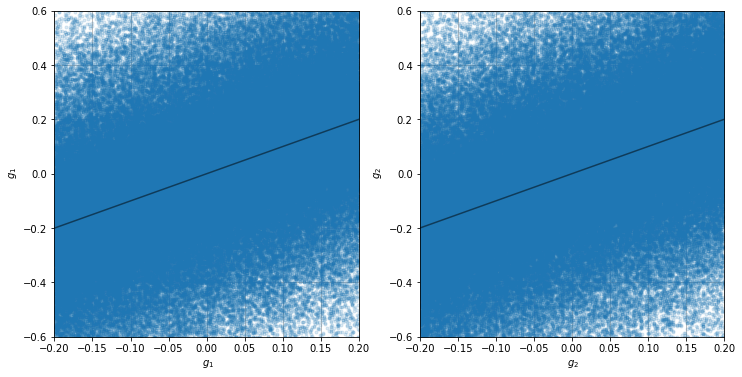

In [9]:
psf_radius = (0.12 / 0.065) / 2.355
radii = half_light_radii(x_seq_test)

y_seq_rrg = rrg_shapes(x_seq_test, radii, psf_radius)
inds = np.all(np.abs(y_seq_rrg) < 1.0, axis=1)

y_seq_rrg_calibed, calib_rrg, rmse_rrg = step_bias_calib(y_seq_test[inds], y_seq_rrg[inds], verbose=True)
show_scatter_label_pred(y_seq_test[inds], y_seq_rrg_calibed, min_g=-0.6, max_g=0.6, min_g_true=-0.2, max_g_true=0.2)

In [10]:
shears = {'tru': y_seq_test[inds], 'rrg': y_seq_rrg_calibed, 'cnn': y_seq_ptta_calibed[inds]}

In [11]:
count, edges, _ = binned_statistic(shears['tru'][:,0], shears['tru'][:,0]*0, bins=16, range=[-0.2,0.2], statistic='count')

mse_rrg0 = binned_statistic(shears['tru'][:,0], (shears['rrg'][:,0] - shears['tru'][:,0])**2, bins=16, range=[-0.2,0.2])[0]
mse_cnn0 = binned_statistic(shears['tru'][:,0], (shears['cnn'][:,0] - shears['tru'][:,0])**2, bins=16, range=[-0.2,0.2])[0]
bias_rrg0 = binned_statistic(shears['tru'][:,0], (shears['rrg'][:,0] - shears['tru'][:,0]), bins=16, range=[-0.2,0.2])[0]
bias_cnn0 = binned_statistic(shears['tru'][:,0], (shears['cnn'][:,0] - shears['tru'][:,0]), bins=16, range=[-0.2,0.2])[0]

mse_rrg1 = binned_statistic(shears['tru'][:,1], (shears['rrg'][:,1] - shears['tru'][:,1])**2, bins=16, range=[-0.2,0.2])[0]
mse_cnn1 = binned_statistic(shears['tru'][:,1], (shears['cnn'][:,1] - shears['tru'][:,1])**2, bins=16, range=[-0.2,0.2])[0]
bias_rrg1 = binned_statistic(shears['tru'][:,1], (shears['rrg'][:,1] - shears['tru'][:,1]), bins=16, range=[-0.2,0.2])[0]
bias_cnn1 = binned_statistic(shears['tru'][:,1], (shears['cnn'][:,1] - shears['tru'][:,1]), bins=16, range=[-0.2,0.2])[0]
cents = (edges[:-1] + edges[1:]) / 2

In [12]:
bias_rrg0_errs = (mse_rrg0 / count)**0.5
bias_rrg1_errs = (mse_rrg1 / count)**0.5
bias_cnn0_errs = (mse_cnn0 / count)**0.5
bias_cnn1_errs = (mse_cnn1 / count)**0.5

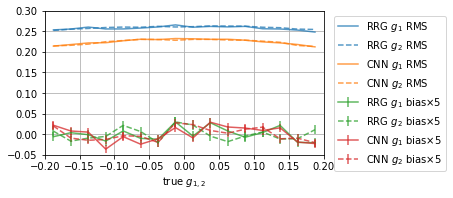

In [13]:
plt.figure(figsize=(5,2.65))

plt.plot(cents, mse_rrg0**0.5, '-', color='C0', label='RRG $g_1$ RMS', alpha=0.75)
plt.plot(cents, mse_rrg1**0.5, '--', color='C0', label='RRG $g_2$ RMS', alpha=0.75)
plt.plot(cents, mse_cnn0**0.5, '-', color='C1', label='CNN $g_1$ RMS', alpha=0.75)
plt.plot(cents, mse_cnn1**0.5, '--', color='C1', label='CNN $g_2$ RMS', alpha=0.75)

plt.errorbar(cents, bias_rrg0*5, yerr=bias_rrg0_errs*5, fmt='-', color='C2', label='RRG $g_1$ bias$\\times 5$', alpha=0.75)
plt.errorbar(cents, bias_rrg1*5, yerr=bias_rrg1_errs*5, fmt='--', color='C2', label='RRG $g_2$ bias$\\times 5$', alpha=0.75)
plt.errorbar(cents, bias_cnn0*5, yerr=bias_cnn0_errs*5, fmt='-', color='C3', label='CNN $g_1$ bias$\\times 5$', alpha=0.75)
plt.errorbar(cents, bias_cnn1*5, yerr=bias_cnn1_errs*5, fmt='--', color='C3', label='CNN $g_2$ bias$\\times 5$', alpha=0.75)

plt.xlabel('true $g_{1,2}$')
#plt.legend()
plt.legend(bbox_to_anchor=(1.02,1.0))
plt.ylim([-0.05, 0.3])
plt.xlim([-0.2, 0.2])
plt.grid()
#plt.gcf().subplots_adjust(bottom=0.15, left=0.15, right=0.82)

if save_figures:
    fig_path = expanduser(config['figure_path'] + '/performance/performance_per_shear.pdf')
    plt.savefig(fig_path, bbox_inches='tight')

In [14]:
from astropy.table import Table
from astropy.io import ascii

In [15]:
rmse_rrg = np.mean((shears['rrg'] - shears['tru'])**2, axis=0)**0.5
rmse_ptta = np.mean((shears['cnn'] - shears['tru'])**2, axis=0)**0.5

In [16]:
c1 = [calib_rrg[0], calib_ptta[0]]
m1 = [calib_rrg[1], calib_ptta[1]]
c2 = [calib_rrg[2], calib_ptta[2]]
m2 = [calib_rrg[3], calib_ptta[3]]
sigma1 = [rmse_rrg[0], rmse_ptta[0]]
sigma2 = [rmse_rrg[1], rmse_ptta[1]]
estimators = ['RRG', 'CNN']
names = [' ', '$c_1$', '$m_1$', '$c_2$', '$m_2$', '$\\sigma_1$', '$\\sigma_2$']
rows = [estimators, c1, m1, c2, m2, sigma1, sigma2]
tbl_perf_overall = Table(rows, names=names)

In [17]:
tbl_perf_overall['$c_1$'].format = '1.4f'
tbl_perf_overall['$m_1$'].format = '1.3f'
tbl_perf_overall['$c_2$'].format = '1.4f'
tbl_perf_overall['$m_2$'].format = '1.3f'
tbl_perf_overall['$\\sigma_1$'].format = '1.3f'
tbl_perf_overall['$\\sigma_2$'].format = '1.3f'

In [18]:
tbl_perf_overall

,$c_1$,$m_1$,$c_2$,$m_2$,$\sigma_1$,$\sigma_2$
str3,float64,float64,float64,float64,float64,float64
RRG,0.0007,0.119,-0.0004,0.121,0.257,0.259
CNN,0.0001,0.005,-0.0001,0.005,0.225,0.224


In [19]:
if save_table:
    tbl_path = expanduser(config['figure_path'] + '/performance/perf_overall.tex')
    tbl_perf_overall.write(tbl_path, format='ascii.latex', latexdict=ascii.latex.latexdicts['AA'], col_align='lcccccr',
                           caption="Calibration parameters and RMS errors of the two calibrated estimators.")